<a href="https://colab.research.google.com/github/FernandoSimon22/vision_artificial/blob/main/Faster_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
from torchvision import transforms as T
import matplotlib.pyplot as plt
from PIL import Image

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="lX9sE2RPQOCv2R7cn0io")
project = rf.workspace("jota22").project("am_boundingbox")
version = project.version(14)
dataset = version.download("coco")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to AM_BoundingBox-14 in coco:: 100%|██████████| 198/198 [00:00<00:00, 5532.13it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define transformations
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # Convert PIL image to tensor
        return image, target

In [3]:
# Dataset class
# 👇 Solo en notebooks (si aún no lo has hecho)
!pip install pycocotools


class CocoDetectionFasterRCNN(CocoDetection):
    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        boxes = []
        labels = []

        for obj in target:
            x, y, w, h = obj['bbox']
            if w > 0 and h > 0:
                boxes.append([x, y, x + w, y + h])
                labels.append(obj['category_id'])

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.tensor([], dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            "iscrowd": torch.zeros((len(labels),), dtype=torch.int64)
        }
        return img, target


import torchvision.transforms as T

class SimpleTransform:
    def __call__(self, image, target=None):
        return T.ToTensor()(image), target


def get_coco_dataset(img_dir, ann_file):
    return CocoDetectionFasterRCNN(
        root=img_dir,
        annFile=ann_file,
        transforms=SimpleTransform()
    )


# Load datasets
train_dataset = get_coco_dataset(
    img_dir="/content/AM_BoundingBox-14/train",
    ann_file="/content/AM_BoundingBox-14/train/_annotations.coco.json"
)

val_dataset = get_coco_dataset(
    img_dir="/content/AM_BoundingBox-14/valid",
    ann_file="/content/AM_BoundingBox-14/valid/_annotations.coco.json"
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
img, target = train_dataset[0]
print(img.shape)
print(target)


torch.Size([3, 592, 592])
{'boxes': tensor([[311., 570., 338., 584.],
        [342., 467., 356., 490.],
        [285., 501., 302., 513.],
        [360., 503., 379., 516.],
        [312., 317., 328., 338.],
        [455., 399., 466., 412.],
        [393., 375., 405., 391.],
        [351., 197., 364., 231.],
        [354., 169., 365., 193.],
        [356., 123., 367., 153.],
        [358.,  87., 369., 118.],
        [358.,  56., 370.,  82.],
        [362.,  12., 372.,  48.],
        [364.,   4., 373.,   9.],
        [470., 298., 479., 309.],
        [195., 518., 210., 534.],
        [414., 326., 426., 344.],
        [368., 457., 382., 480.],
        [283., 468., 303., 489.],
        [358., 546., 383., 561.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'image_id': tensor([0]), 'area': tensor([378., 322., 204., 247., 336., 143., 192., 442., 264., 330., 341., 312.,
        360.,  45.,  99., 240., 216., 322., 420., 375.]), 'iscrowd': tensor([0, 0, 0, 0, 

In [4]:
# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [5]:
# Initialize the model
num_classes = 2 # background + def
model = get_model(num_classes)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 211MB/s]


In [6]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [7]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    running_loss = 0.0

    for images, targets in data_loader:
        # Enviar a dispositivo
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    avg_loss = running_loss / len(data_loader)
    print(f"Epoch [{epoch}] Loss: {avg_loss:.4f}")
    return avg_loss


In [ ]:
 # --- GUARDAR RESULTADOS EN CSV ---
    df_ordenado.to_csv("resultados_comparacion_modelos.csv", index=False)
    print("\n✅ Resultados exportados a 'resultados_comparacion_modelos.csv'")

    return df_ordenado

In [ ]:
log_training(0, 5.123, 6.789)


In [ ]:
import pandas as pd
pd.read_csv("training_val_log.csv")


,Epoch,Train Loss,Val Loss
0,0,5.123,6.789


In [8]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt

# Guardar pérdidas en CSV

def log_training(epoch, train_loss, val_loss, log_path="training_val_log.csv"):
    # Asegura que los valores sean numéricos válidos
    try:
        train_loss = float(train_loss)
    except:
        train_loss = 0.0

    try:
        val_loss = float(val_loss)
    except:
        val_loss = 0.0

    file_exists = os.path.isfile(log_path)
    with open(log_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(["Epoch", "Train Loss", "Val Loss"])
        writer.writerow([epoch, train_loss, val_loss])




In [8]:
def evaluate_loss(model, val_loader, device):
    model.train()  # 👈 Cambiar a modo entrenamiento SOLO para calcular pérdida
    model.to(device)
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(val_loader):
            try:
                images = [img.to(device) for img in images]

                # Filtrar y validar targets
                processed_targets = []
                valid_images = []
                for i, t in enumerate(targets):
                    if 'boxes' in t and len(t['boxes']) > 0:
                        processed_target = {
                            k: v.to(device) if hasattr(v, 'to') else v
                            for k, v in t.items()
                        }
                        processed_targets.append(processed_target)
                        valid_images.append(images[i])

                if not processed_targets:
                    continue

                loss_dict = model(valid_images, processed_targets)
                if isinstance(loss_dict, dict):
                    loss = sum(loss_dict.values()).item()
                    total_loss += loss
                    count += 1
                else:
                    print(f"⚠️ Batch {batch_idx} devolvió un objeto inesperado: {type(loss_dict)}")

            except Exception as e:
                print(f"⚠️ Error evaluando batch de validación: {e}")
                continue

    model.eval()  # 👈 Restaurar modo evaluación después
    return total_loss / count if count > 0 else 0.0




In [10]:
num_epochs = 100

# Eliminar log anterior si existe
import os
if os.path.exists("training_val_log.csv"):
    os.remove("training_val_log.csv")

for epoch in range(num_epochs):
    # Entrenamiento
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)


    # Validación
    val_loss = evaluate_loss(model, val_loader, device)

    print(f"[DEBUG] Epoch {epoch}")
    print("Train Loss:", type(train_loss), train_loss)
    print("Val Loss:", type(val_loss), val_loss)

    # Logging
    log_training(epoch, train_loss, val_loss)  # 👈 Ahora funciona bien

    # Ajuste de learning rate
    optimizer.step()
    lr_scheduler.step()

    # Guardado del modelo
    if (epoch + 1) % 10 == 0:
        model_path = f"fasterrcnn_resnet50_epoch_{epoch + 1}.pth"
        torch.save(model.state_dict(), model_path)
        print(f"✅ Model saved: {model_path}")



Epoch [0] Loss: 1.7815
[DEBUG] Epoch 0
Train Loss: <class 'float'> 1.7815422100179337
Val Loss: <class 'float'> 1.336877554655075
Epoch [1] Loss: 1.2605
[DEBUG] Epoch 1
Train Loss: <class 'float'> 1.2604905998005587
Val Loss: <class 'float'> 1.2434039413928986
Epoch [2] Loss: 1.1586
[DEBUG] Epoch 2
Train Loss: <class 'float'> 1.1586051548228544
Val Loss: <class 'float'> 1.1151916682720184
Epoch [3] Loss: 1.0780
[DEBUG] Epoch 3
Train Loss: <class 'float'> 1.0779502076261185
Val Loss: <class 'float'> 1.0681642889976501
Epoch [4] Loss: 1.0471
[DEBUG] Epoch 4
Train Loss: <class 'float'> 1.0470561455277836
Val Loss: <class 'float'> 1.0570485442876816
Epoch [5] Loss: 1.0439
[DEBUG] Epoch 5
Train Loss: <class 'float'> 1.043913203127244
Val Loss: <class 'float'> 1.0738795548677444
Epoch [6] Loss: 1.0327
[DEBUG] Epoch 6
Train Loss: <class 'float'> 1.0327350427122677
Val Loss: <class 'float'> 1.0683320611715317
Epoch [7] Loss: 1.0353
[DEBUG] Epoch 7
Train Loss: <class 'float'> 1.035251077483682


In [11]:
# Graficar curva de aprendizaje
def plot_train_val_losses(log_path="training_val_log.csv"):
    if not os.path.exists(log_path):
        print("⚠️ No se encontró el archivo de log.")
        return

    df_log = pd.read_csv(log_path)
    if df_log.empty:
        print("⚠️ El archivo de log está vacío.")
        return

    plt.figure(figsize=(10, 5))
    plt.plot(df_log["Epoch"], df_log["Train Loss"], marker='o', label="Pérdida Entrenamiento", color='blue')
    plt.plot(df_log["Epoch"], df_log["Val Loss"], marker='x', label="Pérdida Validación", color='orange')
    plt.title("📉 Evolución de la Pérdida por Época")
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import json
from tqdm import tqdm

# -------------------------
# 1. CONFIGURACIÓN
# -------------------------
VAL_IMG_DIR = "/content/AM_BoundingBox-14/valid"
VAL_ANN_FILE = "/content/AM_BoundingBox-14/valid/_annotations.coco.json"
MODEL_PATH = "/content/fasterrcnn_resnet50_epoch_100.pth"
NUM_CLASSES = 2  # Ajusta según tus categorías

# -------------------------
# 2. DATASET PERSONALIZADO
# -------------------------
class CocoValDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        image_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes, labels = [], []
        for ann in anns:
            if ann['iscrowd'] == 0 and ann['bbox'][2] > 0 and ann['bbox'][3] > 0:
                x, y, w, h = ann['bbox']
                boxes.append([x, y, x + w, y + h])
                labels.append(ann['category_id'])

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([image_id]),
        }

        if self._transforms:
            img = self._transforms(img)

        return img, target

# -------------------------
# 3. CARGAR MODELO
# -------------------------
def load_model(path, num_classes, device):
    model = fasterrcnn_resnet50_fpn(weights=None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    return model

# -------------------------
# 4. MAIN: CARGA + INFERENCIA
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model(MODEL_PATH, NUM_CLASSES, device)

val_dataset = CocoValDataset(VAL_IMG_DIR, VAL_ANN_FILE, transforms=ToTensor())
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

coco_gt = COCO(VAL_ANN_FILE)
results = []

for images, targets in tqdm(val_loader):
    images = list(img.to(device) for img in images)
    outputs = model(images)

    for target, output in zip(targets, outputs):
        image_id = int(target["image_id"])
        boxes = output["boxes"].detach().cpu().numpy()
        scores = output["scores"].detach().cpu().numpy()
        labels = output["labels"].detach().cpu().numpy()

        for box, score, label in zip(boxes, scores, labels):
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min

            results.append({
                "image_id": image_id,
                "category_id": int(label),
                "bbox": [float(x_min), float(y_min), float(width), float(height)],
                "score": float(score)
            })

# -------------------------
# 5. GUARDAR Y EVALUAR
# -------------------------
with open("detections.json", "w") as f:
    json.dump(results, f, indent=2)

coco_gt = COCO("./AM_BoundingBox-14/valid/_annotations.coco.json")
coco_dt = coco_gt.loadRes("detections.json")

evaluator = COCOeval(coco_gt, coco_dt, iouType="bbox")
evaluator.evaluate()
evaluator.accumulate()
evaluator.summarize()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


100%|██████████| 30/30 [00:02<00:00, 11.02it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.91s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.416
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

In [19]:
# --- MEJORADO: Evaluar todas las imágenes del conjunto de validación y visualizar ---

import os
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

from tqdm import tqdm

from torchvision import transforms

# --- CONFIGURACIÓN ---
num_classes = 2  # 1 clase + fondo
model_path = "/content/fasterrcnn_resnet50_epoch_100.pth"
img_dir = "/content/AM_BoundingBox-14/test"  # <-- Cambia esto si es necesario
ann_file = "/content/AM_BoundingBox-14/test/_annotations.coco.json"

# --- CARGAR MODELO ---
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# --- COCO DATASET & LOADER ---
def get_transform():
    return transforms.Compose([
        transforms.ToTensor()
    ])

def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(root=img_dir, annFile=ann_file, transform=get_transform())

dataset = get_coco_dataset(img_dir, ann_file)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
# --- FUNCIONES DE DIBUJO ---
COCO_CLASSES = {0: "background", 1: "def"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "unknown")

def draw_boxes(image, prediction, threshold=0.5):
    draw = ImageDraw.Draw(image)
    boxes = prediction["boxes"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            x_min, y_min, x_max, y_max = box
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
            draw.text((x_min, y_min), f"{get_class_name(label)} ({score:.2f})", fill="red")
    return image

# --- EVALUAR Y GUARDAR RESULTADOS DE TODAS LAS IMÁGENES ---
out_dir = "detections"
os.makedirs(out_dir, exist_ok=True)

with torch.no_grad():
    for idx, (images, targets) in enumerate(tqdm(val_loader, desc="Evaluando")):
        image_tensor = images[0].to(device)
        output = model([image_tensor])[0]

        # Cargar imagen original para visualizar
        image_path = dataset.ids[idx]
        image_file = dataset.coco.loadImgs(image_path)[0]['file_name']
        image = Image.open(os.path.join(img_dir, image_file)).convert("RGB")

        # Dibujar predicciones
        result_img = draw_boxes(image.copy(), output)

        # Guardar
        result_img.save(os.path.join(out_dir, f"prediction_{idx+1}.jpg"))

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Evaluando: 100%|██████████| 25/25 [00:02<00:00,  8.48it/s]


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_train_val_losses(log_path="/content/training_val_log.csv"):
    if not os.path.exists(log_path):
        print("⚠️ No se encontró el archivo de log.")
        return

    df_log = pd.read_csv(log_path)
    if df_log.empty:
        print("⚠️ El archivo de log está vacío.")
        return

    plt.figure(figsize=(10, 5))
    plt.plot(df_log["Epoch"], df_log["Train Loss"], marker='o', label="Pérdida Entrenamiento", color='blue')
    plt.plot(df_log["Epoch"], df_log["Val Loss"], marker='x', label="Pérdida Validación", color='orange')
    plt.title("📉 Evolución de la Pérdida por Época")
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.


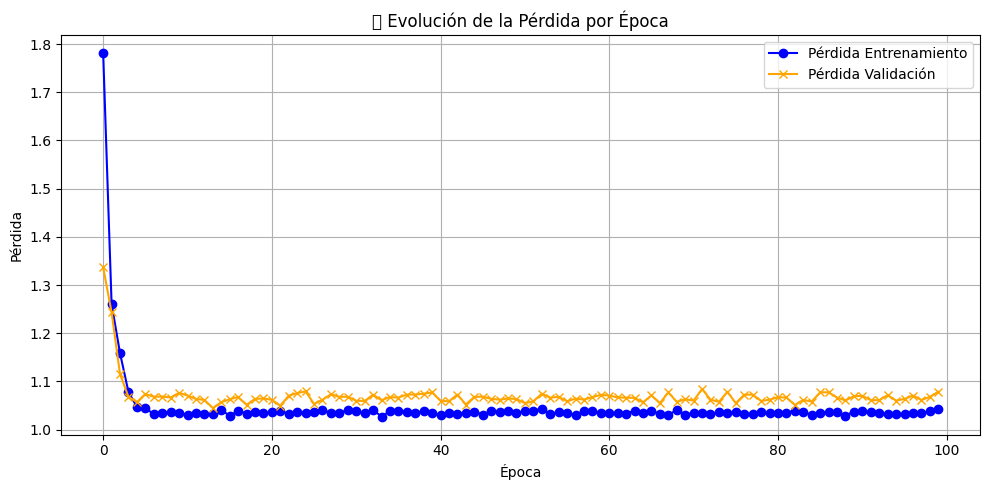

In [13]:
plot_train_val_losses()


In [ ]:
images, targets = next(iter(val_loader))
print(targets[0])


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluando modelo: /content/fasterrcnn_resnet50_epoch_105.pth


Evaluando modelo:  75%|███████▌  | 6/8 [00:00<00:00, 50.32it/s]

⚠️ [Batch 0] No valid targets found in this batch: ([{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [321, 58, 14.67, 9.33], 'area': 136.871, 'segmentation': [], 'iscrowd': 0}, {'id': 1, 'image_id': 0, 'category_id': 1, 'bbox': [375, 46, 20, 8.67], 'area': 173.4, 'segmentation': [], 'iscrowd': 0}, {'id': 2, 'image_id': 0, 'category_id': 1, 'bbox': [437, 57, 16, 10], 'area': 160, 'segmentation': [], 'iscrowd': 0}, {'id': 3, 'image_id': 0, 'category_id': 1, 'bbox': [409, 62, 18, 8.67], 'area': 156.06, 'segmentation': [], 'iscrowd': 0}, {'id': 4, 'image_id': 0, 'category_id': 1, 'bbox': [507, 3, 16, 9.33], 'area': 149.28, 'segmentation': [], 'iscrowd': 0}, {'id': 5, 'image_id': 0, 'category_id': 1, 'bbox': [550, 9, 14, 6], 'area': 84, 'segmentation': [], 'iscrowd': 0}, {'id': 6, 'image_id': 0, 'category_id': 1, 'bbox': [593, 40, 11.33, 11.33], 'area': 128.369, 'segmentation': [], 'iscrowd': 0}, {'id': 7, 'image_id': 0, 'category_id': 1, 'bbox': [539, 68, 20, 10], 'area': 200, 'segmenta

Evaluando modelo: 100%|██████████| 8/8 [00:00<00:00, 52.57it/s]


⚠️ [Batch 7] No valid targets found in this batch: ([{'id': 1292, 'image_id': 28, 'category_id': 1, 'bbox': [79, 607, 23.12, 20.15], 'area': 465.868, 'segmentation': [], 'iscrowd': 0}, {'id': 1293, 'image_id': 28, 'category_id': 1, 'bbox': [337, 194, 20.24, 21.87], 'area': 442.649, 'segmentation': [], 'iscrowd': 0}, {'id': 1294, 'image_id': 28, 'category_id': 1, 'bbox': [335, 104, 20.58, 16.3], 'area': 335.454, 'segmentation': [], 'iscrowd': 0}, {'id': 1295, 'image_id': 28, 'category_id': 1, 'bbox': [105, 232, 12.62, 18.05], 'area': 227.791, 'segmentation': [], 'iscrowd': 0}, {'id': 1296, 'image_id': 28, 'category_id': 1, 'bbox': [337, 304, 20.92, 13.9], 'area': 290.788, 'segmentation': [], 'iscrowd': 0}, {'id': 1297, 'image_id': 28, 'category_id': 1, 'bbox': [354, 241, 12.75, 18.88], 'area': 240.72, 'segmentation': [], 'iscrowd': 0}, {'id': 1298, 'image_id': 28, 'category_id': 1, 'bbox': [317, 74, 8.59, 23.55], 'area': 202.295, 'segmentation': [], 'iscrowd': 0}, {'id': 1299, 'image_id

Evaluando modelo:   0%|          | 0/8 [00:00<?, ?it/s]

⚠️ [Batch 0] No valid targets found in this batch: ([{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [321, 58, 14.67, 9.33], 'area': 136.871, 'segmentation': [], 'iscrowd': 0}, {'id': 1, 'image_id': 0, 'category_id': 1, 'bbox': [375, 46, 20, 8.67], 'area': 173.4, 'segmentation': [], 'iscrowd': 0}, {'id': 2, 'image_id': 0, 'category_id': 1, 'bbox': [437, 57, 16, 10], 'area': 160, 'segmentation': [], 'iscrowd': 0}, {'id': 3, 'image_id': 0, 'category_id': 1, 'bbox': [409, 62, 18, 8.67], 'area': 156.06, 'segmentation': [], 'iscrowd': 0}, {'id': 4, 'image_id': 0, 'category_id': 1, 'bbox': [507, 3, 16, 9.33], 'area': 149.28, 'segmentation': [], 'iscrowd': 0}, {'id': 5, 'image_id': 0, 'category_id': 1, 'bbox': [550, 9, 14, 6], 'area': 84, 'segmentation': [], 'iscrowd': 0}, {'id': 6, 'image_id': 0, 'category_id': 1, 'bbox': [593, 40, 11.33, 11.33], 'area': 128.369, 'segmentation': [], 'iscrowd': 0}, {'id': 7, 'image_id': 0, 'category_id': 1, 'bbox': [539, 68, 20, 10], 'area': 200, 'segmenta

Evaluando modelo: 100%|██████████| 8/8 [00:00<00:00, 53.96it/s]

⚠️ [Batch 1] No valid targets found in this batch: ([{'id': 247, 'image_id': 4, 'category_id': 1, 'bbox': [408, 286, 39.92, 9.38], 'area': 374.45, 'segmentation': [], 'iscrowd': 0}, {'id': 248, 'image_id': 4, 'category_id': 1, 'bbox': [452, 287, 47.14, 8.27], 'area': 389.848, 'segmentation': [], 'iscrowd': 0}, {'id': 249, 'image_id': 4, 'category_id': 1, 'bbox': [503, 288, 55.46, 8.16], 'area': 452.554, 'segmentation': [], 'iscrowd': 0}, {'id': 250, 'image_id': 4, 'category_id': 1, 'bbox': [565, 288, 26.34, 8.49], 'area': 223.627, 'segmentation': [], 'iscrowd': 0}, {'id': 251, 'image_id': 4, 'category_id': 1, 'bbox': [600, 289, 36.11, 8.83], 'area': 318.851, 'segmentation': [], 'iscrowd': 0}, {'id': 252, 'image_id': 4, 'category_id': 1, 'bbox': [28, 201, 15.99, 10.02], 'area': 160.22, 'segmentation': [], 'iscrowd': 0}, {'id': 253, 'image_id': 4, 'category_id': 1, 'bbox': [179, 296, 17.07, 9.13], 'area': 155.849, 'segmentation': [], 'iscrowd': 0}, {'id': 254, 'image_id': 4, 'category_id


Evaluando modelo: /content/fasterrcnn_resnet50_epoch_135.pth


Evaluando modelo: 100%|██████████| 8/8 [00:00<00:00, 52.62it/s]

⚠️ [Batch 0] No valid targets found in this batch: ([{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [321, 58, 14.67, 9.33], 'area': 136.871, 'segmentation': [], 'iscrowd': 0}, {'id': 1, 'image_id': 0, 'category_id': 1, 'bbox': [375, 46, 20, 8.67], 'area': 173.4, 'segmentation': [], 'iscrowd': 0}, {'id': 2, 'image_id': 0, 'category_id': 1, 'bbox': [437, 57, 16, 10], 'area': 160, 'segmentation': [], 'iscrowd': 0}, {'id': 3, 'image_id': 0, 'category_id': 1, 'bbox': [409, 62, 18, 8.67], 'area': 156.06, 'segmentation': [], 'iscrowd': 0}, {'id': 4, 'image_id': 0, 'category_id': 1, 'bbox': [507, 3, 16, 9.33], 'area': 149.28, 'segmentation': [], 'iscrowd': 0}, {'id': 5, 'image_id': 0, 'category_id': 1, 'bbox': [550, 9, 14, 6], 'area': 84, 'segmentation': [], 'iscrowd': 0}, {'id': 6, 'image_id': 0, 'category_id': 1, 'bbox': [593, 40, 11.33, 11.33], 'area': 128.369, 'segmentation': [], 'iscrowd': 0}, {'id': 7, 'image_id': 0, 'category_id': 1, 'bbox': [539, 68, 20, 10], 'area': 200, 'segmenta

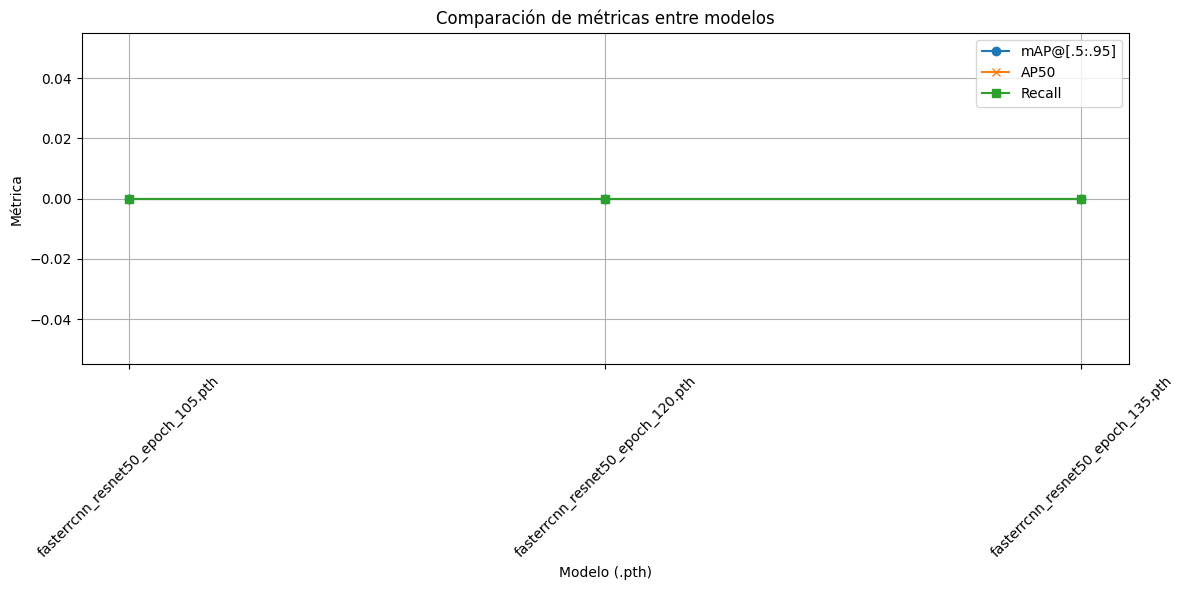


✅ Resultados exportados a 'resultados_comparacion_modelos.csv'


In [ ]:
# --- COMPARAR VARIOS MODELOS .PTH ---
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def compare_models(model_paths, model, val_loader, annotations_path, device="cuda"):
    resultados = []
    for path in model_paths:
        model.load_state_dict(torch.load(path, map_location=device))
        print(f"\nEvaluando modelo: {path}")
        metrics = evaluate_model(model, val_loader, annotations_path, output_json="predictions_temp.json", device=device)
        resultados.append({
            "modelo": os.path.basename(path),
            "mAP@[.5:.95]": metrics["map"],
            "AP50": metrics["ap50"],
            "Recall": metrics["recall"],
            "Box Loss": metrics["box_loss"],
            "Cls Loss": metrics["cls_loss"]
        })

    df = pd.DataFrame(resultados)
    df_ordenado = df.sort_values(by="mAP@[.5:.95]", ascending=False)
    print("\n📊 Comparación de modelos:")
    print(df_ordenado.to_string(index=False))

    # --- GRAFICAR RESULTADOS ---
    plt.figure(figsize=(12, 6))
    plt.plot(df_ordenado['modelo'], df_ordenado['mAP@[.5:.95]'], label='mAP@[.5:.95]', marker='o')
    plt.plot(df_ordenado['modelo'], df_ordenado['AP50'], label='AP50', marker='x')
    plt.plot(df_ordenado['modelo'], df_ordenado['Recall'], label='Recall', marker='s')
    plt.xlabel("Modelo (.pth)")
    plt.ylabel("Métrica")
    plt.title("Comparación de métricas entre modelos")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- GUARDAR RESULTADOS EN CSV ---
    df_ordenado.to_csv("resultados_comparacion_modelos.csv", index=False)
    print("\n✅ Resultados exportados a 'resultados_comparacion_modelos.csv'")

    return df_ordenado


# --- EJECUCIÓN PRINCIPAL ---
if __name__ == "__main__":
    # Lista de modelos a comparar
    model_paths = [
        "/content/fasterrcnn_resnet50_epoch_105.pth",
        "/content/fasterrcnn_resnet50_epoch_120.pth",
        "/content/fasterrcnn_resnet50_epoch_135.pth"
    ]

    # Crear modelo base
    def get_model(num_classes):
        model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

    model = get_model(num_classes= 2)  # Ajusta según tu dataset
    device = "cuda" if torch.cuda.is_available() else "cpu"

     # Preparar val_loader
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    val_dataset = CocoDetection(
        root="/content/AM_BoundingBox-14/valid",
        annFile="/content/AM_BoundingBox-14/valid/_annotations.coco.json",
        transform=transform
    )

    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    # Ruta a las anotaciones COCO del conjunto de validación
    annotations_path = "/content/AM_BoundingBox-14/valid/_annotations.coco.json"

    # Ejecutar comparación
    df_resultados = compare_models(model_paths, model, val_loader, annotations_path, device=device)
